<a href="https://colab.research.google.com/github/ibenatar-96/statistical-rethinking-numpyro/blob/main/chapter_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q numpyro arviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 3.8 MB/s eta 0:00:00


In [13]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import lax, random, vmap
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation

In [3]:
sppnames = [
    "afarensis",
    "africanus",
    "habilis",
    "boisei",
    "rudolfensis",
    "ergaster",
    "sapiens",
]
brainvolcc = jnp.array([438, 452, 612, 521, 752, 871, 1350])
masskg = jnp.array([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})

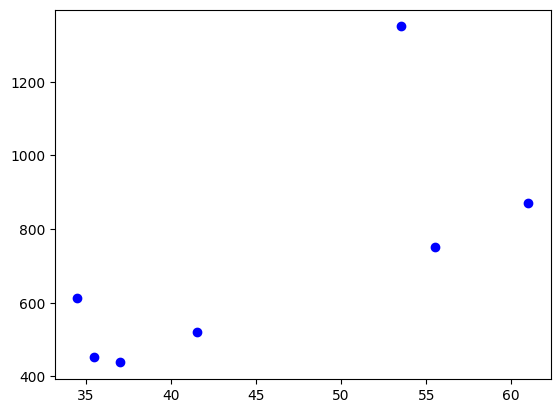

In [8]:
plt.plot(masskg, brainvolcc, 'bo')
plt.show()

In [4]:
d["mass_std"] = (d.mass - d.mass.mean()) / d.mass.std()
d["brain_std"] = d.brain / d.brain.max()

In [11]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic("mu", a + b * mass_std)
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_1 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m7_1,
    optim.Adam(0.3),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p7_1 = svi_result.params

100%|██████████| 1000/1000 [00:00<00:00, 2281.76it/s, init loss: 115.9437, avg. loss [951-1000]: 3.6486]


In [12]:
samples = m7_1.sample_posterior(random.PRNGKey(1), p7_1, sample_shape=(1000,))
print_summary(samples, 0.89, False)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
          a      0.53      0.07      0.54      0.42      0.64    931.50      1.00
          b      0.17      0.08      0.17      0.06      0.30   1111.41      1.00
  log_sigma     -1.70      0.30     -1.70     -2.16     -1.21    950.16      1.00
      mu[0]      0.40      0.09      0.41      0.24      0.53    892.72      1.00
      mu[1]      0.38      0.10      0.38      0.21      0.52    879.78      1.00
      mu[2]      0.37      0.10      0.37      0.19      0.51    875.23      1.00
      mu[3]      0.47      0.07      0.48      0.36      0.59    958.46      1.00
      mu[4]      0.69      0.10      0.68      0.54      0.85   1004.71      1.00
      mu[5]      0.77      0.13      0.77      0.57      0.97   1043.57      1.00
      mu[6]      0.66      0.09      0.65      0.53      0.81    985.80      1.00



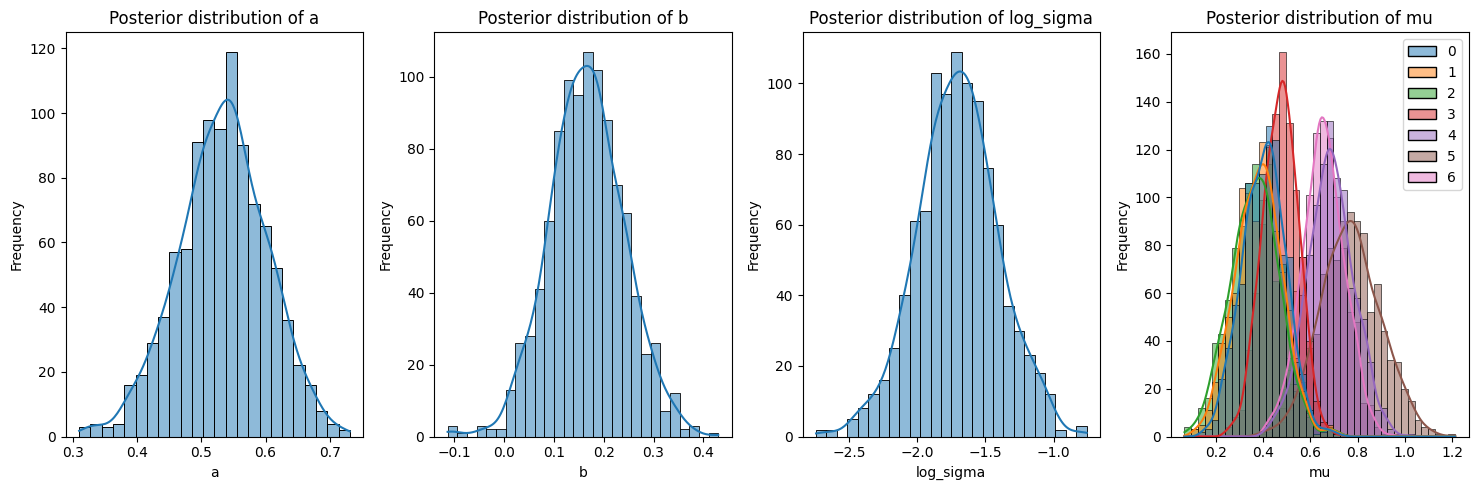

In [14]:
# For multiple parameters, you can create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(samples), figsize=(15, 5))

for ax, (param, values) in zip(axes, samples.items()):
    sns.histplot(values, kde=True, ax=ax)
    ax.set_title(f'Posterior distribution of {param}')
    ax.set_xlabel(param)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
# Using the Predictive function to generate posterior predictive samples
s = Predictive(m7_1.model, samples)(random.PRNGKey(2), d.mass_std.values)

# Calculating the residuals by subtracting observed brain_std values from the mean of predicted brain_std values
r = jnp.mean(s["brain_std"], 0) - d.brain_std.values

# Calculating the variance of the residuals
resid_var = jnp.var(r, ddof=1)

# Calculating the variance of the observed brain_std values
outcome_var = jnp.var(d.brain_std.values, ddof=1)

# Calculating the proportion of variance explained (R-squared)
1 - resid_var / outcome_var

Array(0.4536283, dtype=float32)

In [16]:
def R2_is_bad(quap_fit):
    # Unpack the quap_fit tuple into quap and params
    quap, params = quap_fit

    # Sampling from the posterior distribution using provided parameters
    post = quap.sample_posterior(random.PRNGKey(1), params, sample_shape=(1000,))

    # Using the Predictive function to generate posterior predictive samples
    s = Predictive(quap.model, post)(random.PRNGKey(2), d.mass_std.values)

    # Calculating the residuals by subtracting observed brain_std values from the mean of predicted brain_std values
    r = jnp.mean(s["brain_std"], 0) - d.brain_std.values

    # Calculating the proportion of variance explained (R-squared)
    return 1 - jnp.var(r, ddof=1) / jnp.var(d.brain_std.values, ddof=1)

In [17]:
# Define the probabilistic model
def model(mass_std, brain_std=None):
    # Sample the intercept 'a' from a normal distribution with mean 0.5 and standard deviation 1
    a = numpyro.sample("a", dist.Normal(0.5, 1))

    # Sample the coefficients 'b' (with two parameters) from a normal distribution with mean 0 and standard deviation 10
    b = numpyro.sample("b", dist.Normal(0, 10).expand([2]))

    # Sample the log of the standard deviation 'log_sigma' from a normal distribution with mean 0 and standard deviation 1
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))

    # Define the deterministic function for the mean 'mu'
    mu = numpyro.deterministic("mu", a + b[0] * mass_std + b[1] * mass_std**2)

    # Sample 'brain_std' from a normal distribution with mean 'mu' and standard deviation 'exp(log_sigma)'
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)

# Initialize the AutoLaplaceApproximation with the model and initial values for 'b'
m7_2 = AutoLaplaceApproximation(
    model, init_loc_fn=init_to_value(values={"b": jnp.repeat(0.0, 2)})
)

# Initialize the Stochastic Variational Inference (SVI) method
svi = SVI(
    model,                 # The probabilistic model
    m7_2,                  # The variational distribution
    optim.Adam(0.3),       # The optimizer (Adam with learning rate 0.3)
    Trace_ELBO(),          # The Evidence Lower Bound (ELBO) loss function
    mass_std=d.mass_std.values,  # The standardized mass data
    brain_std=d.brain_std.values # The standardized brain data
)

# Run the SVI algorithm for 2000 iterations
svi_result = svi.run(random.PRNGKey(0), 2000)

# Extract the parameters of the variational approximation
p7_2 = svi_result.params

100%|██████████| 2000/2000 [00:00<00:00, 2999.58it/s, init loss: 19.0172, avg. loss [1901-2000]: 6.6279]


In [18]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([3]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + b[0] * mass_std + b[1] * mass_std**2 + b[2] * mass_std**3
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_3 = AutoLaplaceApproximation(
    model, init_loc_fn=init_to_value(values={"b": jnp.repeat(0.0, 3)})
)
svi = SVI(
    model,
    m7_3,
    optim.Adam(0.01),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p7_3 = svi_result.params


def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([4]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + jnp.sum(b * jnp.power(mass_std[..., None], jnp.arange(1, 5)), -1)
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_4 = AutoLaplaceApproximation(
    model, init_loc_fn=init_to_value(values={"b": jnp.repeat(0.0, 4)})
)
svi = SVI(
    model,
    m7_4,
    optim.Adam(0.01),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p7_4 = svi_result.params


def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([5]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + jnp.sum(b * jnp.power(mass_std[..., None], jnp.arange(1, 6)), -1)
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_5 = AutoLaplaceApproximation(
    model, init_loc_fn=init_to_value(values={"b": jnp.repeat(0.0, 5)})
)
svi = SVI(
    model,
    m7_5,
    optim.Adam(0.01),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p7_5 = svi_result.params

100%|██████████| 2000/2000 [00:01<00:00, 1025.48it/s, init loss: 28.6818, avg. loss [1901-2000]: 8.2398]


In [19]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([6]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + jnp.sum(b * jnp.power(mass_std[..., None], jnp.arange(1, 7)), -1)
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_6 = AutoLaplaceApproximation(
    model, init_loc_fn=init_to_value(values={"b": jnp.repeat(0.0, 6)})
)
svi = SVI(
    model,
    m7_6,
    optim.Adam(0.003),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
svi_result = svi.run(random.PRNGKey(0), 5000)
p7_6 = svi_result.params

100%|██████████| 5000/5000 [00:01<00:00, 3802.15it/s, init loss: 31.9033, avg. loss [4751-5000]: 9.2882]


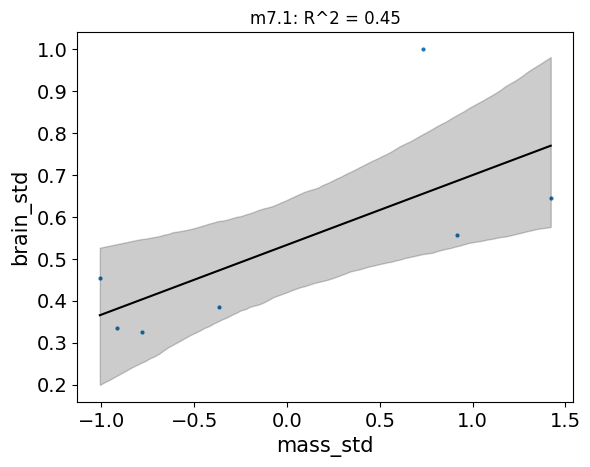

In [20]:
# Sampling from the posterior distribution using provided parameters
post = m7_1.sample_posterior(random.PRNGKey(1), p7_1, sample_shape=(1000,))

# Remove the "mu" key from the posterior samples
post.pop("mu")

# Create a sequence of mass values ranging from the minimum to the maximum standardized mass
mass_seq = jnp.linspace(d.mass_std.min(), d.mass_std.max(), num=100)

# Generate posterior predictive samples for the mean "mu" across the mass sequence
l = Predictive(m7_1.model, post, return_sites=["mu"])(
    random.PRNGKey(2), mass_std=mass_seq
)["mu"]

# Calculate the mean of the predictive samples for "mu"
mu = jnp.mean(l, 0)

# Calculate the 5.5th and 94.5th percentiles for the predictive samples of "mu"
ci = jnp.percentile(l, jnp.array([5.5, 94.5]), 0)

# Plot the data points of mass_std vs. brain_std
az.plot_pair(d[["mass_std", "brain_std"]].to_dict("list"))

# Plot the mean predictive line for "mu"
plt.plot(mass_seq, mu, "k")

# Shade the credible interval area between the 5.5th and 94.5th percentiles
plt.fill_between(mass_seq, ci[0], ci[1], color="k", alpha=0.2)

# Set the title of the plot with the R-squared value of the model
plt.title("m7.1: R^2 = {:0.2f}".format(R2_is_bad((m7_1, p7_1)).item()))

# Display the plot
plt.show()
